# **Model and Evaluation**

## Objectives

* Create Train and Test set and Machine Learning Pipeline to answer the second business requirement which is:
    * The client is interested in predicting the house sale price from her four inherited houses and any other house in Ames, Iowa.

## Inputs

* The clean and feature engineered datasets are located at: outputs/dataset/collection

## Outputs

* Train set (features and target)* 
Test set (features and target
* Modeling Pipeline. 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Fabrizio-Project-Five/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname('/workspaces/Fabrizio-Project-Five/jupyter_notebooks'))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/Fabrizio-Project-Five'

Before starting our model notebook we will create a cell where we will place all of our imports and we'll create a folder where to store the various results from this notebook

In [4]:
version = 'v1'
filepath = f'outputs/ml_pipeline/predict_saleprice/{version}'
try:
    os.makedirs(name=filepath)
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_saleprice/v1'


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.selection import DropCorrelatedFeatures
from feature_engine.outliers import Winsorizer
from feature_engine.selection import DropFeatures

# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# Import GridSearchCV for model score evaluation
from sklearn.model_selection import GridSearchCV

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

# metrics for model evaluation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 

/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Splitting the Dataset

In this section we will split the dataset in Train and Test set in order to prepare it for model training. The test set will be 20% of the whole dataset just to make sure we are adherent to ML initial best practices.

In [5]:
df_fe = pd.read_csv('outputs/dataset/collection/clean_dataset.csv')
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379 entries, 0 to 1378
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   1stFlrSF       1379 non-null   int64  
 1   2ndFlrSF       1379 non-null   float64
 2   BedroomAbvGr   1379 non-null   float64
 3   BsmtExposure   1379 non-null   object 
 4   BsmtFinSF1     1379 non-null   int64  
 5   BsmtFinType1   1379 non-null   object 
 6   BsmtUnfSF      1379 non-null   int64  
 7   EnclosedPorch  1379 non-null   float64
 8   GarageArea     1379 non-null   int64  
 9   GarageFinish   1379 non-null   object 
 10  GarageYrBlt    1379 non-null   float64
 11  GrLivArea      1379 non-null   int64  
 12  KitchenQual    1379 non-null   object 
 13  LotArea        1379 non-null   int64  
 14  LotFrontage    1379 non-null   float64
 15  MasVnrArea     1379 non-null   float64
 16  OpenPorchSF    1379 non-null   int64  
 17  OverallCond    1379 non-null   int64  
 18  OverallQ

In [6]:
X = df_fe.drop('SalePrice', axis=1)
y = df_fe['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=9)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1103, 23) (1103,) 
* Test set: (276, 23) (276,)


As we can see from the result of the .shape attribute called on the various test and train datasets we have achieved our goal. Now we can move on to the ML Pipeline itself.

---

# Regression Pipeline

In this section we will study which regression algorithm is the best one fo our ML business case. The results from the algorithm will also provide us with information that we can use to determine if additional hyperparameter optimization will be needed.

In this cell I have imported code from the Churnometer Walkthrough Project. These two dictionaries list first the type of regression
model we want to try for our ML business case and second a dictionary which will run a search for the default hyperparameters for each model

In [7]:
# Code from the Churnometer Walkthrough Project

models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In the next cell I will import a custom class from the Churnometer Project. Specifically this class will fit all the models listed in the in the previous dictionary and will apply the default hyperparameters (again, as listed in the previous dictionary). The class will also return a DataFrame with the scores for the regression models. This will allow us to select the best model for our Business Case.

In [8]:
# Code from Churnometer Walkthrough Project
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = regression_pipeline(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

In the next cell we will instantiate the Pipeline. The estimators will be described as well.

In [9]:
def regression_pipeline(model):
    pipeline_base = Pipeline([
        # The Ordinal Encoder is used to turn the categorical variables values in numerical
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
        # The SmartCorrelatedSelection is set with a threshold of 0.5 given our previous correlation study
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.5, selection_method="variance")),
        # The feature scaling transformer has been applied because there were features with different units in the clean dataset 
        ("feature_scaling", StandardScaler()),
        # This transformer will select the best feature for prediction
        ("feature_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base    

In [10]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

In [11]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.627016,0.810786,0.880247,0.094096
2,RandomForestRegressor,0.648496,0.810041,0.871683,0.083003
5,GradientBoostingRegressor,0.604829,0.807643,0.883576,0.104356
6,XGBRegressor,0.59238,0.778298,0.851396,0.096646
4,AdaBoostRegressor,0.546628,0.712067,0.786351,0.085148
0,LinearRegression,0.290525,0.664679,0.787911,0.188717
1,DecisionTreeRegressor,0.318006,0.599628,0.742074,0.155964


In the above cell we can see that the best regressor for our business case is the 'Extra Trees Regressor'. The mean score for 'R2' is already above the 0.75 value that we set as our goal. Nonetheless we can still conduct a more in-depth hyperparameter search to look for a fine tuned model that could give us even a more precise outcome.

In [12]:
models_quick_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_quick_search = {
    'ExtraTreesRegressor': {
        'model__n_estimators': [10, 50, 100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10, 20]
    }
}

In [13]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=10)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 10 folds for each of 80 candidates, totalling 800 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

In [14]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_split,model__n_estimators
24,ExtraTreesRegressor,0.419245,0.816949,0.920085,0.137816,10,2,300
49,ExtraTreesRegressor,0.462841,0.816774,0.90707,0.122716,20,5,300
48,ExtraTreesRegressor,0.460287,0.81666,0.904388,0.123591,20,5,200
54,ExtraTreesRegressor,0.536941,0.816558,0.89267,0.097824,20,10,300
23,ExtraTreesRegressor,0.418141,0.816435,0.917692,0.137884,10,2,200
...,...,...,...,...,...,...,...,...
75,ExtraTreesRegressor,0.555962,0.797351,0.871221,0.083841,30,20,10
55,ExtraTreesRegressor,0.555962,0.797351,0.871221,0.083841,20,20,10
65,ExtraTreesRegressor,0.411713,0.795227,0.89277,0.134189,30,5,10
5,ExtraTreesRegressor,0.411713,0.795227,0.89277,0.134189,None,5,10


As we can see from our previous cells, even after 640 fits of our pipeline the best hyperparameters were found on the very first fit. 

* Model max depth: The best value for this hyperparameter is 10. That means that the algorithm ran until the trees in the forest reached a depth of 10
* Minimum sample split: The best value for this is 2. This means that 2 was the minimum number of samples required to split and internal node.
* Number of Estimators: The best value for this is 300. This means that we had 300 trees in our forest.

Now if we run the next cell we have our best regression pipeline, including the hyperparameters that gave us the best R2 score.

In [15]:
best_model = grid_search_summary.iloc[0,0]
grid_search_pipelines[best_model].best_params_
regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.5,
                                          variables=['1stFlrSF', '2ndFlrSF',
                                                     'BedroomAbvGr',
                                                     'BsmtExposure',
                                                     'BsmtFinSF1',...
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'KitchenQual', 'LotArea',
                                                     'LotFront

After having found our best pipeline we need to evaluate the performance using the metrics we have decided in our business case assesment. 

In [16]:
prediction = regressor_pipeline.predict(X_train)
regression_r2_metric = r2_score(y_train, prediction)
test_set_prediction = regressor_pipeline.predict(X_test)
r2_metric_test_set = r2_score(y_test, test_set_prediction)
print('r2 metric on train set: ', regression_r2_metric, '\n'
      'r2 metric on test set: ', r2_metric_test_set)
    

r2 metric on train set:  0.9730592873807028 
r2 metric on test set:  0.6744196968167399


Our r2 score for the test set is too low while on the train set is too high. A classic case of overfitting. Our best move now is to tweak our hyperparameters to see if the pipeline will give us a test set r2 score that we can accept. In addition to that we will also set the threshold for our Smart Correlated Selection to 0.8 compared to the previous 0.5

In [17]:
def regression_pipeline(model):
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
        # The SmartCorrelatedSelection is set with a threshold of 0.8 given our previous correlation study
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.8, selection_method="variance")),
        # The feature scaling transformer has been applied because there were features with different units in the clean dataset 
        ("feature_scaling", StandardScaler()),
        # This transformer will select the best feature for prediction
        ("feature_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base 

In [18]:
models_quick_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_quick_search = {
    'ExtraTreesRegressor': {
        'model__n_estimators': [10, 50, 100],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10, 20],
        'model__max_features': [None]
    }
}

# For reference these below were our previous hyperparameters
"""
params_quick_search = {
    'ExtraTreesRegressor': {
        'model__n_estimators': [10, 50, 100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10, 20]
    }
}
"""

"\nparams_quick_search = {\n    'ExtraTreesRegressor': {\n        'model__n_estimators': [10, 50, 100, 200, 300],\n        'model__max_depth': [None, 10, 20, 30],\n        'model__min_samples_split': [2, 5, 10, 20]\n    }\n}\n"

In [19]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

In [20]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_split,model__n_estimators
20,ExtraTreesRegressor,0.688411,0.801594,0.845575,0.058109,10,None,10,100
32,ExtraTreesRegressor,0.689046,0.799154,0.852336,0.057957,20,None,10,100
19,ExtraTreesRegressor,0.675847,0.798987,0.846371,0.062573,10,None,10,50
44,ExtraTreesRegressor,0.688139,0.798795,0.852346,0.058196,30,None,10,100
8,ExtraTreesRegressor,0.688139,0.798795,0.852346,0.058196,None,None,10,100
31,ExtraTreesRegressor,0.689869,0.7984,0.858212,0.058301,20,None,10,50
7,ExtraTreesRegressor,0.687841,0.797951,0.858279,0.058909,None,None,10,50
43,ExtraTreesRegressor,0.687841,0.797951,0.858279,0.058909,30,None,10,50
45,ExtraTreesRegressor,0.741108,0.797868,0.835365,0.031652,30,None,20,10
9,ExtraTreesRegressor,0.741108,0.797868,0.835365,0.031652,None,None,20,10


Now that we have a new best set of hyperparameters we can run our r2 score evaluation again.

In [21]:
best_model = grid_search_summary.iloc[0,0]
grid_search_pipelines[best_model].best_params_
regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          variables=['1stFlrSF', '2ndFlrSF',
                                                     'BedroomAbvGr',
                                                     'BsmtExposure',
                                                     'BsmtFinSF1',
                                                     'BsmtFinType1'...
                                                     'KitchenQual', 'LotArea',
                                                     'LotFrontage',
                                                     'MasVnrArea

In [22]:
train_set_prediction = regressor_pipeline.predict(X_train)
regression_r2_metric = r2_score(y_train, train_set_prediction)
test_set_prediction = regressor_pipeline.predict(X_test)
r2_metric_test_set = r2_score(y_test, test_set_prediction)
print('r2 metric on train set: ', regression_r2_metric, '\n'
      'r2 metric on test set: ', r2_metric_test_set)

r2 metric on train set:  0.8906685622204683 
r2 metric on test set:  0.754663640384859


Finally we were able to have an r2 score slightly above 0.75 on both train and test set. The difference in the 2 values still shows us some overfitting. Despite having reached the threshold for the r2 metric on both the train and test set we can try to improve the model a bit more to achive a better result.

Let's try to add some more feature engineering steps to the pipeline.

In [23]:
def regression_pipeline(model):
    pipeline_base = Pipeline([
        # dropping features that in the original dataset were mostly missing data
        ("drop_features", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        # The Ordinal Encoder is used to turn the categorical variables values in numerical
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'])),
        # using the iqr values to normalize the outliers in the dataset
        ("Outlier_handling", Winsorizer(capping_method='iqr', tail='both', fold=1.5)),
        # dropping features that are too strongly correlated with each other
        ("DropCorrelatedFeatures", DropCorrelatedFeatures(method='spearman', threshold=0.9)),
        # The SmartCorrelatedSelection is set with a threshold of 0.8 given our previous correlation study
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.8, selection_method="variance")),
        # The feature scaling transformer has been applied because there were features with different units in the clean dataset
        ("feature_scaling", StandardScaler()),
        # This transformer will select the best feature for prediction
        ("feature_selection",  SelectFromModel(model)),
        # Chosen ML model
        ("model", model),

    ])

    return pipeline_base

In [24]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

In [25]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_split,model__n_estimators
19,ExtraTreesRegressor,0.74615,0.807727,0.8442,0.035941,10,None,10,50
32,ExtraTreesRegressor,0.753263,0.807725,0.841496,0.032003,20,None,10,100
44,ExtraTreesRegressor,0.753744,0.807531,0.839486,0.031578,30,None,10,100
8,ExtraTreesRegressor,0.753744,0.807515,0.839406,0.031562,None,None,10,100
20,ExtraTreesRegressor,0.744827,0.80738,0.841558,0.035267,10,None,10,100
18,ExtraTreesRegressor,0.750664,0.807101,0.855683,0.036504,10,None,10,10
23,ExtraTreesRegressor,0.763447,0.80651,0.847617,0.028736,10,None,20,100
22,ExtraTreesRegressor,0.759101,0.805975,0.847712,0.029775,10,None,20,50
34,ExtraTreesRegressor,0.767699,0.805716,0.850868,0.02827,20,None,20,50
46,ExtraTreesRegressor,0.767699,0.805716,0.850868,0.02827,30,None,20,50


In [26]:
best_model = grid_search_summary.iloc[0,0]
grid_search_pipelines[best_model].best_params_
regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
regressor_pipeline

Pipeline(steps=[('drop_features',
                 DropFeatures(features_to_drop=['EnclosedPorch',
                                                'WoodDeckSF'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['BsmtExposure', 'BsmtFinType1',
                                           'GarageFinish', 'KitchenQual'])),
                ('Outlier_handling',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['1stFlrSF', '2ndFlrSF', 'Be...
                                                     'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                                     'OverallCond',
                                                     'OverallQual',
                                                     'Tota

In [28]:
train_set_prediction = regressor_pipeline.predict(X_train)
regression_r2_metric = r2_score(y_train, train_set_prediction)
test_set_prediction = regressor_pipeline.predict(X_test)
r2_metric_test_set = r2_score(y_test, test_set_prediction)
print('r2 metric on train set: ', regression_r2_metric, '\n'
      'r2 metric on test set: ', r2_metric_test_set)

r2 metric on train set:  0.8991142787283698 
r2 metric on test set:  0.7951346767155878


As we can see with out modifications to the pipeline we are now able to achieve a better result for the test set. The train set still shows a value that suggests a possible overfitting problem.

* These are the 5 most important features in descending order. The model was trained on them: 
['OverallQual', 'GrLivArea', 'KitchenQual', 'TotalBsmtSF', 'GarageArea']


<Figure size 1200x800 with 0 Axes>

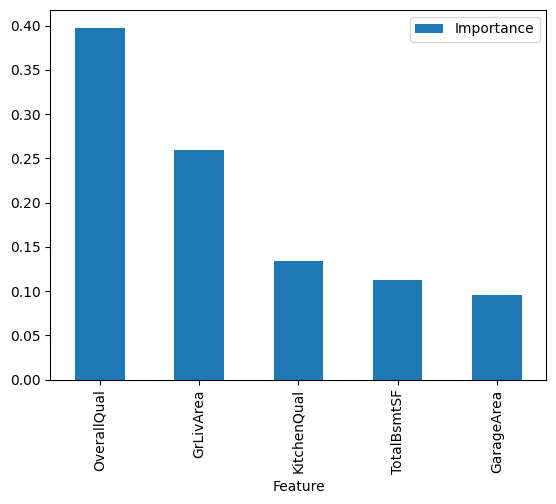

In [29]:
# code taken from CI Churnometer Walkthrough 
data_cleaning_feat_eng_steps = 5 # how many data cleaning and feature engineering does your pipeline have?
columns_after_data_cleaning_feat_eng = (Pipeline(regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[regressor_pipeline['feature_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[regressor_pipeline['feature_selection'].get_support()],
    'Importance': regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")
plt.figure(figsize=(12, 8)) 
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.savefig('/workspaces/Fabrizio-Project-Five/outputs/ml_pipeline/predict_saleprice/features_importance.png')
plt.show()

These are the most important features the model found. Let' refit the pipeline with only the best features.

In [30]:
# In this cell I will create a smaller pipeline to predict the data by feeding the filtered dataset with the most important features
def regression_pipeline(model):
    pipeline_base = Pipeline([
        # ("drop_features", DropFeatures(features_to_drop=['EnclosedPorch', 'WoodDeckSF'])),
        # The Ordinal Encoder is used to turn the categorical variables values in numerical
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['KitchenQual'])),
        ("Outlier_handling", Winsorizer(capping_method='iqr', tail='both', fold=1.5)),
        # ("DropCorrelatedFeatures", DropCorrelatedFeatures(method='spearman', threshold=0.9)),
        # The SmartCorrelatedSelection is set with a threshold of 0.5 given our previous correlation study
        # ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
        #  method="spearman", threshold=0.8, selection_method="variance")),
        # The feature scaling transformer has been applied because there were features with different units in the clean dataset
        ("feature_scaling", StandardScaler()),
        # This transformer will select the best feature for prediction
        # ("feature_selection",  SelectFromModel(model)),
        # This transformer will extract and group the most significant features
        # ("Principal Component Analysis", PCA(n_components=23)),
        # Chosen ML model
        ("model", model),

    ])

    return pipeline_base

In [31]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

* Train set: (1103, 5) (1103,) 
* Test set: (276, 5) (276,)


,GarageArea,GrLivArea,KitchenQual,OverallQual,TotalBsmtSF
229,440,1928,Fa,6,1020
1106,433,1261,TA,6,1261
64,576,2207,TA,7,1947


In [32]:
# This is the best model with the hyperparameters already optimized
models_quick_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_quick_search = {
    'ExtraTreesRegressor': {
        'model__n_estimators': [50],
        'model__max_depth': [10],
        'model__min_samples_split': [10],
        'model__max_features': [None]
    }
}

In [34]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [35]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__min_samples_split,model__n_estimators
0,ExtraTreesRegressor,0.739316,0.80663,0.857259,0.037996,10,None,10,50


In [36]:
best_model = grid_search_summary.iloc[0,0]
grid_search_pipelines[best_model].best_params_
regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['KitchenQual'])),
                ('Outlier_handling',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['GarageArea', 'GrLivArea', 'KitchenQual',
                                       'OverallQual', 'TotalBsmtSF'])),
                ('feature_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_depth=10, max_features=None,
                                     min_samples_split=10, n_estimators=50,
                                     random_state=0))])

In [37]:
train_set_prediction = regressor_pipeline.predict(X_train)
regression_r2_metric = r2_score(y_train, train_set_prediction)
test_set_prediction = regressor_pipeline.predict(X_test)
r2_metric_test_set = r2_score(y_test, test_set_prediction)
mse_test = mean_squared_error(y_test, test_set_prediction)
mse_train = mean_squared_error(y_train, train_set_prediction)
mae_test = mean_absolute_error(y_test, test_set_prediction)
mae_train = mean_absolute_error(y_train, train_set_prediction)
print('r2 metric on train set: ', regression_r2_metric, '\n'
      'r2 metric on test set: ', r2_metric_test_set, '\n'
      'mse metric on train set: ', mse_train, '\n'
      'mse metric on test set: ', mse_test, '\n'
      'mae metric on train set: ', mae_train, '\n'
      'mae metric on test set: ', mae_test)

r2 metric on train set:  0.8991142787283698 
r2 metric on test set:  0.7951346767155878 
mse metric on train set:  653943249.7785436 
mse metric on test set:  1072123302.2093868 
mae metric on train set:  15708.020727425685 
mae metric on test set:  21222.555591120028


As we can see from the r2 score on the train and test set the values are the same as our previous model. Now we can plot the model performance.

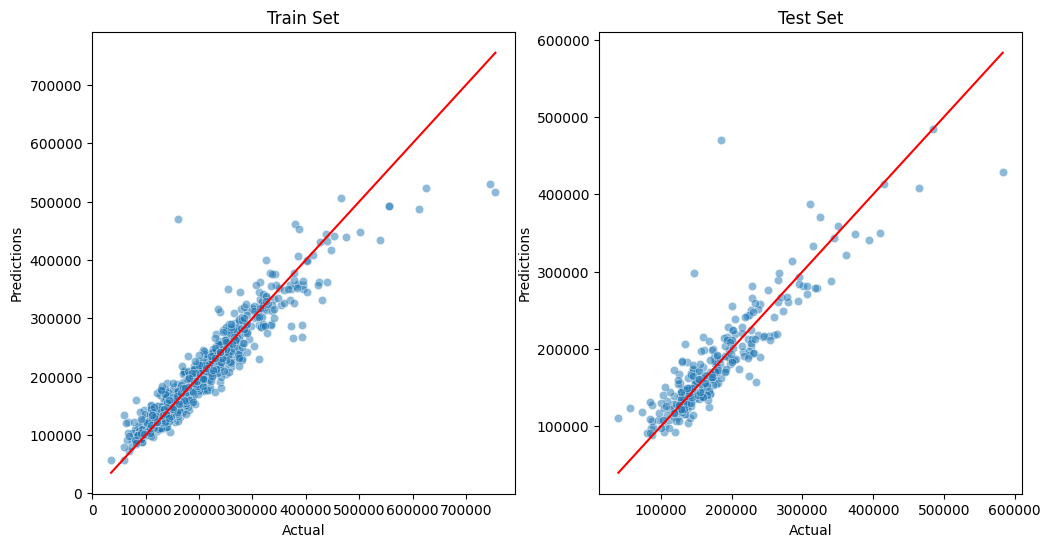

/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

In [40]:
# This function was taken from the Churnometer Walkthrough project.

def model_scatterplots(X_train, y_train, X_test, y_test, pipeline):
    test_prediction = pipeline.predict(X_test)
    train_prediction = pipeline.predict(X_train)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=train_prediction, alpha=0.5, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=test_prediction, alpha=0.5, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.savefig('/workspaces/Fabrizio-Project-Five/outputs/ml_pipeline/predict_saleprice/model_performance.png')
    plt.show()
model_scatterplots(X_train, y_train, X_test, y_test, regressor_pipeline)

Now we can save the regressor pipeline as a pkl file and the train and test sets in order to be able to reuse them in the dashboard.

In [41]:
regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['KitchenQual'])),
                ('Outlier_handling',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['GarageArea', 'GrLivArea', 'KitchenQual',
                                       'OverallQual', 'TotalBsmtSF'])),
                ('feature_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_depth=10, max_features=None,
                                     min_samples_split=10, n_estimators=50,
                                     random_state=0))])

In [42]:
joblib.dump(value=regressor_pipeline, filename=f"outputs/ml_pipeline/predict_saleprice/v1/regressor_pipeline.pkl")

['outputs/ml_pipeline/predict_saleprice/v1/regressor_pipeline.pkl']

In [47]:
print(f"X_train\n {X_train}\n y_train\n {y_train}\n X_test\n {X_test}\n y_test\n {y_test}")

X_train
       GarageArea  GrLivArea KitchenQual  OverallQual  TotalBsmtSF
229          440       1928          Fa            6         1020
1106         433       1261          TA            6         1261
64           576       2207          TA            7         1947
874          612       1686          TA            6         1686
561          216       1368          TA            6          684
...          ...        ...         ...          ...          ...
56           641       2945          Gd           10         1410
501          392        827          TA            5            0
638          264        923          TA            6          923
348          576       1287          Gd            5         1063
382          240       1639          TA            6         1064

[1103 rows x 5 columns]
 y_train
 229     137000
1106    163000
64      180000
874     207500
561     114504
         ...  
56      438780
501     107500
638     143000
348     162000
382     115000

In [48]:
X_train.to_csv(f"outputs/ml_pipeline/predict_saleprice/v1/X_train.csv", index=False)
y_train.to_csv(f"outputs/ml_pipeline/predict_saleprice/v1/y_train.csv", index=False)
X_test.to_csv(f"outputs/ml_pipeline/predict_saleprice/v1/X_test.csv", index=False)
y_test.to_csv(f"outputs/ml_pipeline/predict_saleprice/v1/y_test.csv", index=False)